### Finite Mixture Models - Intro and Bayesian Implementation in Python

Thanks for checking out my note on finite mixture models.  My goal is to give the reader a solid understanding of why mixture models are useful.  I wrote this for people who have studied Bayesian statistics, but I think even those who have only taken a semester or two of statistics can get something out of it.

Feel free to e-mail me with your thoughts and questions: samueljleonard@gmail.com

***

##### Motivation

Imagine you are asked to summarize the results of $1000$ math SAT scores.  If you're feeling lazy that day, you'd probably assume that the scores are drawn from a normal distribution with mean equal to the sample mean and variance equal to the sample variance and leave it at that.  From this model you can make predictions, test hypotheses, etc.

Now assume you are given $1000$ SAT scores, but the data is split into two groups.  $500$ of the students did not study a single minute for the exam, while $500$ went through a rigorous tutoring program.  In this case it doesn't make sense to lump the groups together.  Instead, you might perform two separate analyses.  Let the sample mean and variance of the tutored group summarize their performance, and let the sample mean and sample variance of the students who did not study summarize their scores.  Then you could use these two separate models to make predictions, test hypotheses, etc.

But what if your data doesn't tell you who studied and who didn't?   

This is where finite mixture models come in.  Finite mixture models allow statisiticians to model data that might be drawn from two or more distinct subpopulations, as in this SAT example.  What's cool about these models is that you don't need to know a priori which data points belong to which subpopulation.  The mixture model will (probably) figure it out on it's own.


##### Some Math

Now that we understand what the goal of finite mixture models we can do some math.   

Here are the variables I'll be using:

$y_{i}$ $-$ a student's SAT score

$\theta_{1}$ $-$ the mean of the normal distribution modeling students who did not study

$\theta_{2}$ $-$ the mean of the normal distribution modeling students who were tutored

$\sigma^{2}_{1},\ \sigma^{2}_{2}$ $-$ the variance of the normal distribution modeling each subpopulation

$\lambda_{1}$ $-$ the proportion of the $1000$ students belonging to group $1$

$\lambda_{2}$ $-$ the proportion of the $1000$ students belonging to group $2$


Assume we know the true value for each of these parameters, but not which student belongs to which population.  What would be the probability that a students test score is in the range 500-600?  

Let's assume that the scores of the two subpopulations of students do indeed follow distinct normal distributions.

\begin{equation}
\begin{split}
p(500 \leq y_{i} \leq 600 |\ \theta_{1, 2},\ \sigma^{2}_{1, 2},\ \lambda_{1, 2}) =\ &p(500 \leq y_{i} \leq 600 |\ \textrm{student not tutored})*p(\textrm{student not tutored})\ +\\
&p(500 \leq y_{i} \leq 600 |\ \textrm{student tutored})*p(\textrm{student tutored})
\end{split}
\end{equation}

Which means that

\begin{equation}
\begin{split}
p(500 \leq y_{i} \leq 600 |\ \theta_{1, 2},\ \sigma^{2}_{1, 2},\ \lambda_{1, 2}) &=\ \lambda_{1}\int_{500}^{600}\textrm{Normal}(\theta_{1},\ \sigma^{2}_{1})dy_{i}\ +\
\lambda_{2}\int_{500}^{600}\textrm{Normal}(\theta_{2},\ \sigma^{2}_{2})dy_{i}\\
&=\ \int_{500}^{600}\lambda_{1}\textrm{Normal}(\theta_{1},\ \sigma^{2}_{1})\ +\ \lambda_{2}\textrm{Normal}(\theta_{2},\ \sigma^{2}_{2})dy_{i}
\end{split}
\end{equation}


So the way the math works out, the density function (the integrand in our example) for a mixture model is just the weighted sum of the distributions which make up the mixture model.  This is the origin of the density function for mixture models you may have seen in textbooks:

$$p(y\ |\ \theta_{1},\ ...,\ \theta_{K},\ \lambda_{1},\ ...,\ \lambda_{k})\ =\ \sum_{i = 1}^{K}\lambda_{i}p(y\ |\ \theta_{i})$$

Where here the $\theta_{i}$ represent parameters for any probability distribution, and the $\lambda_{i}$ represent the probability $y$ is drawn from distribution $i$ so that $\sum \lambda_{i}= 1$.


##### Code and Results of a Bayesian Implementation 

Now we know the motivation for finite mixture models: to model data that is potentially drawn from multiple subpopulations.  And we also have a rough derivation for the density function of a finite mixture model.  

So now let's generate some data and implement a simple example.  I'll use Python to run a Monte Carlo Markov Chain to generate estimates of the relevant parameters.


If you're not familiar with MCMCs don't sweat it.  You'll be able to interpret the visualizations below.  

If you are familiar with MCMCs feel free to e-mail me if you want more info on the priors and resulting full conditionals I'm using.




In [24]:
%matplotlib inline
import matplotlib
import numpy as np
from scipy.stats import norm, dirichlet

sigma = 50
data1 = norm.rvs(425, sigma, 500)
data2 = norm.rvs(575, sigma, 500)
data = np.append(data1, data2)

Here's a dataset consisting of $500$ random draws each from two distinct normal distributions.  The first with a mean of $425$, an approximate mean math SAT score for individuals who did not study, and the second with mean $575$, the mean for students who did receive tutoring.

For the sake of simplicity, I've set the variance of both sitributions at $50$.  We can easily relax this restriction, but for now let's go with it.

In [25]:
K = 30
alpha = 1
n = len(data)
tau = 50
mu0 = 500
theta_vector = norm.rvs(mu0, tau, K)
p = np.repeat(1/K, K)
c = np.random.choice(range(0, K), n, replace = True)

Here are our prior parameters and starting values for the MCMC.  

In [26]:
niter = 300
thetaSam = np.zeros( (niter, K) )
cSam = np.zeros( (niter, n) )
pSam = np.zeros( (niter, K) )

Arrays to store the results of our estimation.

In [27]:
for u in range(niter):
    unique_c = list(set(c))
    for j in unique_c:
        indices = [i for i, x in enumerate(c) if x == j]
        sum_yi = sum(data[i] for i in indices)
        nj = len(indices)
        post_var = 1/(nj/sigma**2+1/tau**2)
        post_mean = (sum_yi/sigma**2)*post_var
        theta_vector[j] = float(norm.rvs(post_mean, post_var**.5, 1))
    
    for j in range(0, n):    
        dist = norm.pdf(data[j], theta_vector, sigma)
        probs = list(i * j for i, j in zip(p, dist))
        probs_normalized = list(i/sum(probs) for i in probs)
        c[j] = int(np.random.choice(range(0, K), 1, p=probs_normalized))
    
    c_extended = np.append(c, np.arange(30))
    counts = np.unique(c_extended, return_counts = True)[1] - 1
    alpha_updated = list(i + alpha/K for i in counts)
    p = dirichlet.rvs(alpha_updated, 1)
    p = p[0].tolist()

    thetaSam[u] = theta_vector
    cSam[u] = c
    pSam[u] = p
    


This is the MCMC, the Bayesian algorithm we are using to estimate the parameters of our finite mixture model.

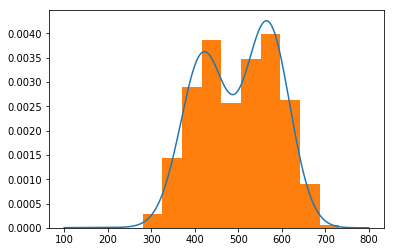

In [28]:
grid = np.arange(100, 800, 1)
fsam = np.zeros( (niter, len(grid)) ) 

for i in range(0, niter):
    fsam[i, ] = [sum(pSam[i, ]*norm.pdf(x, thetaSam[i, ], sigma)) for x in grid]

fy = [np.mean(fsam[:, x]) for x in range(0, len(grid))] 


l = matplotlib.pyplot.plot(grid, fy)
h = matplotlib.pyplot.hist(data, 10, density = True)
matplotlib.pyplot.show()

And here we have a plot of our results.  The orange bars are a normalized histogram of the dataset.  The blue curve is the probability density function estimated from our finite mixture model.  

Looks pretty good!  The MCMC was able to detect the two modes representing the averages for students who studied and did not study.

In the above example, there were exactly $500$ of each type of student.  This of course may not always be the case.  Again, one of the advantages of a finite mixture model is that we do not need to know which students belong to which group, including how many are in each group. 

What if $750$ students were tutored?

Here's what the MCMC looks like in this case.

In [ ]:
data1 = norm.rvs(425, sigma, 250)
data2 = norm.rvs(575, sigma, 750)
data = np.append(data1, data2)
thetaSam = np.zeros( (niter, K) )
cSam = np.zeros( (niter, n) )
pSam = np.zeros( (niter, K) )

for u in range(niter):
    unique_c = list(set(c))
    for j in unique_c:
        indices = [i for i, x in enumerate(c) if x == j]
        sum_yi = sum(data[i] for i in indices)
        nj = len(indices)
        post_var = 1/(nj/sigma**2+1/tau**2)
        post_mean = (sum_yi/sigma**2)*post_var
        theta_vector[j] = float(norm.rvs(post_mean, post_var**.5, 1))
    
    for j in range(0, n):    
        dist = norm.pdf(data[j], theta_vector, sigma)
        probs = list(i * j for i, j in zip(p, dist))
        probs_normalized = list(i/sum(probs) for i in probs)
        c[j] = int(np.random.choice(range(0, K), 1, p=probs_normalized))
    
    c_extended = np.append(c, np.arange(30))
    counts = np.unique(c_extended, return_counts = True)[1] - 1
    alpha_updated = list(i + alpha/K for i in counts)
    p = dirichlet.rvs(alpha_updated, 1)
    p = p[0].tolist()

    thetaSam[u] = theta_vector
    cSam[u] = c
    pSam[u] = p
    
grid = np.arange(100, 800, 1)
fsam = np.zeros( (niter, len(grid)) ) 

for i in range(0, niter):
    fsam[i, ] = [sum(pSam[i, ]*norm.pdf(x, thetaSam[i, ], sigma)) for x in grid]

fy = [np.mean(fsam[:, x]) for x in range(0, len(grid))] 


l = matplotlib.pyplot.plot(grid, fy)
h = matplotlib.pyplot.hist(data, 10, density = True)
matplotlib.pyplot.show()

Looks good again!  

These are, of course, very simple examples of mixture models.  However, it's easy

I will continue to add to this write-up as time permits.  In the meantime feel free to e-mail me with any feedback: SamuelJLeonard@gmail.com

Thanks for reading!